In [1]:
!pip install pythainlp
!pip install deepcut

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Utility
from collections import Counter
import numpy as np

# nltk
from pythainlp.corpus import thai_stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import time

import deepcut

In [3]:
# DATASET
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024


# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [4]:
def tokenize_thai(text):
    token = deepcut.tokenize(text)
    token_with_whitespace = ' '.join(token)
    return token_with_whitespace


In [5]:
# read csv
df_not_clean = pd.read_csv("/content/drive/MyDrive/work/sentiment/sentiment_th/sentiment_one_dependent_variable/sentiment_data_2.csv")
df_not_clean.head()

,comment,comment_without_emo,sentiment,intent
0,เขาเป็นคนดี ช่วยแมวที่กำลังจะตกจากอาคารสูง น่า...,เขาเป็นคนดี ช่วยแมวที่กำลังจะตกจากอาคารสูง น่า...,Positive,Neutral
1,เขาทำงานบกพร่องจนทำให้มีคนเดือดร้อน,เขาทำงานบกพร่องจนทำให้มีคนเดือดร้อน,Negative,Neutral
2,อยากให้เรือหางยาวพุ่งชน,อยากให้เรือหางยาวพุ่งชน,Negative,Neutral
3,โง่ก็แค่อยู่เงียบๆ,โง่ก็แค่อยู่เงียบๆ,Negative,Neutral
4,หล่อทั้งใจหล่อทั้งกาย👏👏👏,หล่อทั้งใจหล่อทั้งกาย,Positive,Neutral


In [6]:
neu_stm = df_not_clean['sentiment'].value_counts()["Neutral"]
neg_stm = df_not_clean['sentiment'].value_counts()["Negative"]
pos_stm = df_not_clean['sentiment'].value_counts()["Positive"]
neu_stm,neg_stm,pos_stm

(502, 374, 373)

In [7]:
df_not_clean.comment_without_emo = df_not_clean.comment_without_emo.apply(lambda x: tokenize_thai(x))

In [8]:
df = df_not_clean[['comment_without_emo','sentiment']]
df.columns = ['text', 'target']
df = df[df['target'] != 'Neutral']
df

,text,target
0,เขา เป็น คน ดี ช่วย แมว ที่ กำลัง จะ ตก จาก ...,Positive
1,เขา ทำ งาน บกพร่อง จน ทำ ให้ มี คน เดือดร้อน,Negative
2,อยาก ให้ เรือ หาง ยาว พุ่ง ชน,Negative
3,โง่ ก็ แค่ อยู่ เงียบ ๆ,Negative
4,หล่อ ทั้งใจ หล่อ ทั้ง กาย,Positive
...,...,...
1227,ใคร ใช้ physiogel ai cream บ้าง ควร ...,Negative
1230,มา สด้า ไทย ฟ้อง ลูกค้า ทำ ได้ ไง,Negative
1231,ใช้ มาสคาร่า เดอะเฟส ชอป แล้ว จะ สวย,Positive
1232,อยาก รู้ ว่า บุหรี่ ไฟ้ ฟ้า เนี่ย มี ผล ต่อ ...,Negative


Text(0.5, 1.0, 'Dataset labels distribuition')

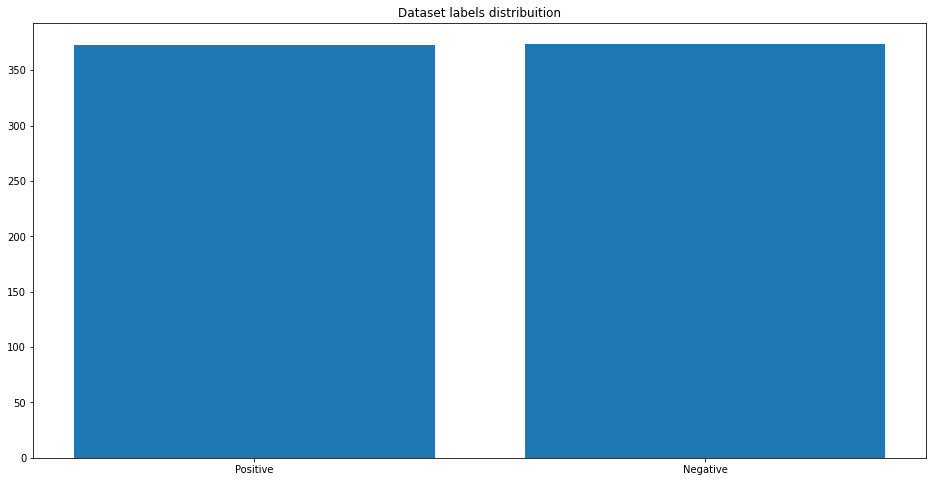

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = thai_stopwords()
print(stop_words)
#ไม่ได้ทำstemmerเพราะยังไม่เจอในไทย
stemmer = SnowballStemmer("english")
print(stemmer)

frozenset({'เสียจน', 'เสียนี่กระไร', 'มีแต่', 'ครั้งครา', 'มัก', 'สิ้น', 'น่าจะ', 'กลุ่มก้อน', 'พอสม', 'ควร', 'เยอะ', 'ที่ละ', 'พอสมควร', 'นาง', 'แต่เมื่อ', 'ทันทีทันใด', 'สิ่งใด', 'ภายนอก', 'แก่', 'ตามๆ', 'ถูก', 'เก็บ', 'แต่ถ้า', 'สิ่ง', 'ปฏิบัติ', 'คราวละ', 'ยังจะ', 'วันนี้', 'ครั้งก่อน', 'เมื่อนั้น', 'เล็กๆ', 'หมดกัน', 'บาง', 'เป็นการ', 'เผื่อจะ', 'คราไหน', 'ขณะหนึ่ง', 'เพราะ', 'คำ', 'ทำไร', 'ข้าง', 'พอจะ', 'ตั้งแต่', 'จรด', 'เฉพาะ', 'เรื่อยๆ', 'มุ่งเน้น', 'ยืนยง', 'เป็นอันๆ', 'เชื่อถือ', 'ซะ', 'อย่างยิ่ง', 'ไม่เป็นไร', 'ช่วงถัดไป', 'นับตั้งแต่', 'นี่แน่ะ', 'ด้วยเหมือนกัน', 'ทุกๆ', 'ดั่งเก่า', 'ใครๆ', 'ค่ะ', 'อย่างเช่น', 'เนื่องจาก', 'พอที่', 'เกี่ยวกับ', 'เพราะว่า', 'กว้าง', 'ครั้งใด', 'นั้นไว', 'ยังแต่', 'แต่ก็', 'อย่างไรก็', 'หรือไง', 'เกิน', 'หรือ', 'ใหญ่ๆ', 'ยืนยัน', 'มองว่า', 'เอง', 'คราวที่', 'เพียงแค่', 'ประการ', 'ต่อ', 'ล้วนแต่', 'ถึงแม้ว่า', 'โดย', 'เป็นๆ', 'ฯล', 'แห่งไหน', 'เท่ากับ', 'ถึงแม้จะ', 'ต้อง', 'ขณะนี้', 'ซะจนถึง', 'ทุกสิ่ง', 'แต่ก่อน', 'สูง', 'ดัง', 'ฝ่ายใด', 'ด

In [11]:
# ทำregular expression เอาคำไหนมา
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [12]:
# %%time
# df.text = df.text.apply(lambda x: preprocess(x))
# df.text

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
print(df_train)
print('=============')
print(df_test)

TRAIN size: 597
TEST size: 150
                                                   text    target
105                                           So   cute  Positive
230     เนื้อ ดี   ส่ง ไว   ไม่ เสียหาย   คุณภาพ สมราคา  Positive
1101  ช่วง เวลา ที่ รู้จัก ถึง จะ ไม่ นาน แต่ คือ ช่...  Positive
352   เบียร์ ช้าง ชิบหาย อะไร   3   ขวด   360   รวย ...  Negative
327   ขับ อีโค่ ของ ฮอนด้า   แล้ว ไป ขับ กระบะ ของ บ...  Negative
...                                                 ...       ...
107               น่าเกลียด มาก อ่ะ แย่ง ผัว เพื่อน รัก  Negative
152                                 มึง โต มา ได้ ไง วะ  Negative
357   เกลียด จริง ๆ ลย   พวก แบบ ขึ้น   #BTS   เวลา ...  Negative
583   ช่วย ผลิต คู่ หลัง   lancer   ex   2 . 0   ด้ว...  Positive
144                              พี่หล่อ มาก ๆ เลย ค้าบ  Positive

[597 rows x 2 columns]
                                                  text    target
274                    ยา โคตร ขม ไม่ อร่อย รสชาติ แย่  Negative
339  สาขา อิมพีเรียลเวิ

In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 
documents

CPU times: user 1.82 ms, sys: 962 µs, total: 2.78 ms
Wall time: 3.03 ms


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 153


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 257 ms, sys: 38.9 ms, total: 296 ms
Wall time: 312 ms


(70679, 254816)

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2112
CPU times: user 19.3 ms, sys: 0 ns, total: 19.3 ms
Wall time: 20 ms


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 20.3 ms, sys: 972 µs, total: 21.3 ms
Wall time: 21.9 ms


In [21]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['Positive', 'Negative', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (597, 1)
y_test (150, 1)


In [23]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (597, 300)
y_train (597, 1)

x_test (150, 300)
y_test (150, 1)


In [24]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(2112, 300)


In [26]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
embedding_layer


In [27]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          633600    
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 794,101
Trainable params: 160,501
Non-trainable params: 633,600
_________________________________________________________________


In [28]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [29]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [30]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1/1 [==============================] - 11s 11s/step - loss: 0.6940 - accuracy: 0.5307 - val_loss: 0.6920 - val_accuracy: 0.5333
Epoch 2/8
1/1 [==============================] - 8s 8s/step - loss: 0.6891 - accuracy: 0.5382 - val_loss: 0.6914 - val_accuracy: 0.5333
Epoch 3/8
1/1 [==============================] - 8s 8s/step - loss: 0.6855 - accuracy: 0.5512 - val_loss: 0.6875 - val_accuracy: 0.5667
Epoch 4/8
1/1 [==============================] - 8s 8s/step - loss: 0.6836 - accuracy: 0.5754 - val_loss: 0.6828 - val_accuracy: 0.5667
Epoch 5/8
1/1 [==============================] - 7s 7s/step - loss: 0.6787 - accuracy: 0.5847 - val_loss: 0.6789 - val_accuracy: 0.5500
Epoch 6/8
1/1 [==============================] - 7s 7s/step - loss: 0.6770 - accuracy: 0.5791 - val_loss: 0.6770 - val_accuracy: 0.5333
Epoch 7/8
1/1 [==============================] - 7s 7s/step - loss: 0.6751 - accuracy: 0.5829 - val_loss: 0.6781 - val_accuracy: 0.5500
Epoch 8/8
1/1 [==============================]

In [31]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 0s 439ms/step - loss: 0.7143 - accuracy: 0.5067

ACCURACY: 0.5066666603088379
LOSS: 0.7142504453659058
CPU times: user 727 ms, sys: 82.1 ms, total: 809 ms
Wall time: 476 ms


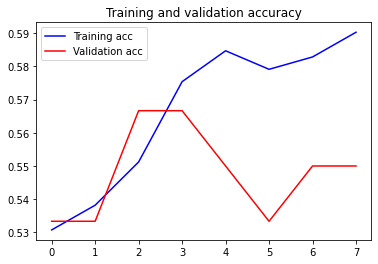

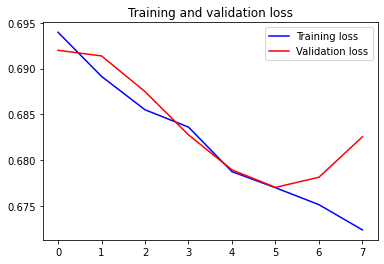

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [33]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [34]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [35]:
predict("ไม่ดี")

{'elapsed_time': 0.34682416915893555,
 'label': 'NEUTRAL',
 'score': 0.5289667844772339}

In [36]:
predict("ดี")

{'elapsed_time': 0.09157586097717285,
 'label': 'NEUTRAL',
 'score': 0.6120583415031433}

In [37]:
predict("เยี่ยมยอด")

{'elapsed_time': 0.1003425121307373,
 'label': 'NEUTRAL',
 'score': 0.5289667844772339}

In [38]:
predict("ดีมาก")

{'elapsed_time': 0.09911894798278809,
 'label': 'NEUTRAL',
 'score': 0.5289667844772339}

In [39]:
predict("เขาเป็นคนดี")

{'elapsed_time': 0.09421586990356445,
 'label': 'NEUTRAL',
 'score': 0.5289667844772339}

In [43]:
predict("ฟาหด่าด่าฟหด่ไ่ำนย่ำนด")

{'elapsed_time': 0.08958959579467773,
 'label': 'NEUTRAL',
 'score': 0.5289667844772339}